<a href="https://colab.research.google.com/github/piyushgoel997/MutationClassification/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports


In [17]:
import numpy as np
import pandas as pd
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, BatchNormalization, GlobalMaxPooling1D
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from keras.utils import plot_model

data_url = "https://raw.githubusercontent.com/piyushgoel997/MutationClassification/master/data.csv"

Using TensorFlow backend.


Load and process data to make matrix

In [2]:
def get_aa_encoder():
    """
    One-hot encoding indices for the 20 possible amino acids.
    :return: the dictionary mapping amino acid to index in the one-hot encoding.
    """
    acids = "ARNDCEQGHILKMFPSTWYV"
    indices = {}
    i = 0
    for a in acids:
        indices[a] = i
        i += 1
    return indices


def make_matrix(seq, alt):
    """
    makes a matrix where each of the 51 features correspond to the amino acid at
    that position in the sequence after the one-hot encoding using the indices
    provided. Also puts a -1 at in the middle most feature at the position
    corresponding to the alt amino acid.
    :param seq: the sequence to be encoded.
    :param alt: the alternate amino acid
    :return: the resultant encoded matrix (51 X 20)
    """
    indices = get_aa_encoder()
    matrix = np.zeros((len(indices), len(seq)))
    i = 0
    for s in seq:
        matrix[indices[s]][i] = 1
        i += 1
    matrix[indices[alt]][int(len(seq) / 2)] = -1
    return matrix.T


def map_description(description):
    map = {'Benign': 0, 'Benign/Likely benign': 0, 'Likely benign': 0,
           'Likely pathogenic': 1, 'Pathogenic': 1, 'Pathogenic/Likely pathogenic': 1}
    return map[description]


X = []
Y = []
mutations = pd.read_csv(data_url)

for _, row in mutations.iterrows():
    X.append(make_matrix(row["REF_SEQ"], row["ALT_AA"]))
    Y.append(map_description(row["DESCRIPTION"]))

X = np.array(X)
Y = np.array(Y)

X, Y = shuffle(X, Y)

print("Input shape", X.shape, "\nOutput shape", Y.shape)

Input shape (229502, 51, 20) 
Output shape (229502,)


In [0]:
def get_model(h=0):
  """
  make, compile and return the model
  :param h: The number of hidden layers with 64 channels to be added
  :return: the model
  """
  model = Sequential()
  model.add(Conv1D(32, kernel_size=3, activation="relu"))
  for _ in range(h):
    model.add(Conv1D(64, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
  model.add(Conv1D(32, kernel_size=3, activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv1D(1, kernel_size=1, activation='sigmoid'))
  model.add(BatchNormalization())
  model.add(GlobalMaxPooling1D())
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
  return model

In [0]:
def k_fold_cross_validation(h, X, Y, k=10, epochs=20):
  """
  Make the model, train it, and validate it using k-fold cross validation.
  :param h: The number of hidden layers with 64 channels to be added in the model.
  :param X: input to the model.
  :param Y: expected outputs of the model.
  :return: average accuracy, avg auc, k roc curve coordinates, k prc curve coordinates.
  """
  avg_accuracy_tain = 0
  avg_accuracy_val = 0
  avg_loss_train = 0
  avg_loss_val = 0
  avg_roc_auc = 0
  roc_curves = []
  prc_curves = []
  for i in range(k):
    model = get_model(h)
    print("========Cross Validation:",str(i) + "/" + str(k) +"========")
    start = int(X.shape[0] * (i / k))
    end = int(X.shape[0] * ((i + 1) / k))
    test_data = X[start:end]
    y_test = Y[start:end]
    train_data = np.concatenate([X[:start], X[end:]])
    y_train = np.concatenate([Y[:start], Y[end:]])
    history = model.fit(train_data, y_train, validation_data=(test_data, y_test), epochs=epochs)
    test_out = model.predict(test_data)
    fpr, tpr, _ = roc_curve(y_test, test_out)
    roc_curves.append((fpr, tpr))
    avg_roc_auc += auc(fpr, tpr)
    p, r, _ = precision_recall_curve(y_test, test_out)
    prc_curves.append((p, r))
    avg_accuracy_tain += history.history['accuracy'][-1]
    avg_accuracy_val += history.history['val_accuracy'][-1]
    avg_loss_train += history.history['loss'][-1]
    avg_loss_val += history.history['val_loss'][-1]
  
  return {"avg_accuracy_train": avg_accuracy_tain / k, "avg_accuracy_val": avg_accuracy_val / k,
          "avg_loss_train": avg_loss_train / k, "avg_loss_val": avg_loss_val / k,
          "avg_roc_auc": avg_roc_auc / k, "roc": roc_curves, "prc": prc_curves}

==========Starting for h = 0==========
=====Cross Validation:  0/2=====
Epoch 1/2
3586/3586 [==============================] - 21s 6ms/step - loss: 0.1690 - accuracy: 0.7984 - val_loss: 0.1372 - val_accuracy: 0.8222
Epoch 2/2
3586/3586 [==============================] - 21s 6ms/step - loss: 0.1067 - accuracy: 0.8516 - val_loss: 0.0939 - val_accuracy: 0.8645
=====Cross Validation:  1/2=====
Epoch 1/2
3586/3586 [==============================] - 22s 6ms/step - loss: 0.1798 - accuracy: 0.7918 - val_loss: 0.1463 - val_accuracy: 0.8201
Epoch 2/2
3586/3586 [==============================] - 22s 6ms/step - loss: 0.1182 - accuracy: 0.8430 - val_loss: 0.0986 - val_accuracy: 0.8621
Final metrics for this model
Average of the final training set accuracy over all folds = 0.8472910821437836
Average of the final training set loss over all folds = 0.11241666972637177
Average of the final validation set accuracy over all folds = 0.8633301854133606
Average of the final validation set accuracy over all 

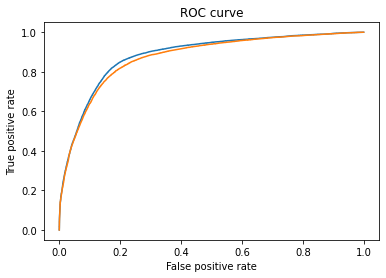

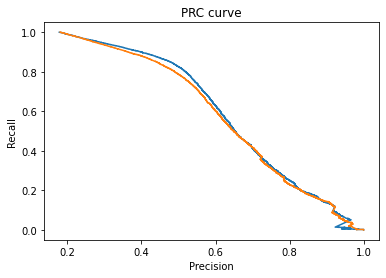

============Finished============
==========Starting for h = 1==========
=====Cross Validation:  0/2=====
Epoch 1/2
3586/3586 [==============================] - 25s 7ms/step - loss: 0.1537 - accuracy: 0.8049 - val_loss: 0.1173 - val_accuracy: 0.8602
Epoch 2/2
3586/3586 [==============================] - 26s 7ms/step - loss: 0.0996 - accuracy: 0.8674 - val_loss: 0.0920 - val_accuracy: 0.8702
=====Cross Validation:  1/2=====
Epoch 1/2
3586/3586 [==============================] - 25s 7ms/step - loss: 0.1549 - accuracy: 0.8091 - val_loss: 0.1135 - val_accuracy: 0.8514
Epoch 2/2
3586/3586 [==============================] - 24s 7ms/step - loss: 0.0959 - accuracy: 0.8694 - val_loss: 0.0905 - val_accuracy: 0.8719
Final metrics for this model
Average of the final training set accuracy over all folds = 0.8683889508247375
Average of the final training set loss over all folds = 0.09773967787623405
Average of the final validation set accuracy over all folds = 0.8710512220859528
Average of the final 

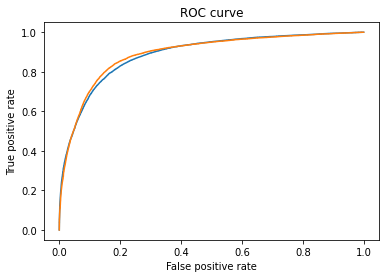

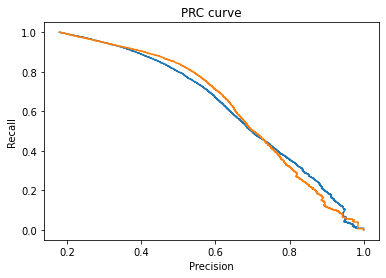

============Finished============
The h value for the best validation accuracy is 1 and the corresponding accuracy is 0.8710512220859528
The h value for the best auc is 1 and the corresponding auc is 0.8897492073768192


In [15]:
best_h_acc = -1  # best h value when chosen based on the validation accuracy.
best_acc = 0
best_h_auc = -1  # best h value when chosen based on the validation auc value.
best_auc = 0

for h in range(2):
  print("==========Starting for h =", str(h) + "==========")

  metrics = k_fold_cross_validation(h, X, Y)
  
  print("Final metrics for this model")
  print("Average of the final training set accuracy over all folds =", str(metrics["avg_accuracy_train"]))
  print("Average of the final training set loss over all folds =", str(metrics["avg_loss_train"]))
  print("Average of the final validation set accuracy over all folds =", str(metrics["avg_accuracy_val"]))
  print("Average of the final validation set accuracy over all folds =", str(metrics["avg_loss_val"]))
  print("Average of the ROC AUC over all folds =", str(metrics["avg_roc_auc"]))

  for c in metrics["roc"]: plt.plot(*c)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.show()

  for c in metrics["prc"]: plt.plot(*c)
  plt.xlabel('Precision')
  plt.ylabel('Recall')
  plt.title('PRC curve')
  plt.show()

  if metrics["avg_accuracy_val"] > best_acc:
    best_h_acc = h
    best_acc = metrics["avg_accuracy_val"]

  if metrics["avg_roc_auc"] > best_auc:
    best_h_auc = h
    best_auc = metrics["avg_roc_auc"]

  print("===============Finished===============")

print("The h value for the best validation accuracy is",str(best_h_acc),"and the corresponding accuracy is",str(best_acc))
print("The h value for the best auc is",str(best_h_auc),"and the corresponding auc is",str(best_auc))

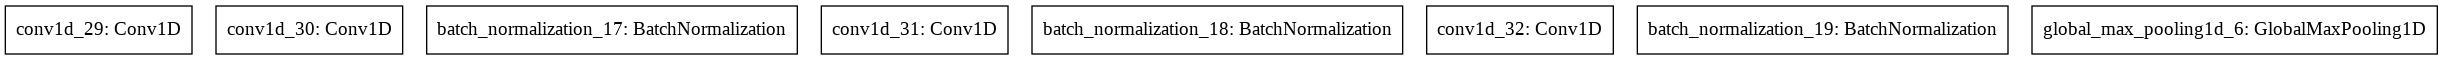

In [18]:
model = get_model(best_h_acc)
X, Y = shuffle(X, Y)

history = model.fit(X, Y, epochs=20)

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plot_model(model, to_file='model.png')